In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.metrics import mean_squared_error


In [16]:
Dwd_50_year_data = pd.read_csv(r'50_years_data.csv',sep= ';')
Dwd_hourly_data_ober_harz = pd.read_csv(r'stunde_2005_2023.csv',sep= ';')
Dwd_daily_brocken = pd.read_csv(r'Daily_data_1896_2023.csv',sep= ';')

## Definations

In [2]:
# resuable code

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def daily_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"daily": variable,
	"models": ["cerra"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_sum = daily.Variables(0).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
	)}
	daily_data["open_meteo"] = daily_sum

	daily_dataframe = pd.DataFrame(data = daily_data)
	if daily_dataframe.empty:
		return print("The daily limit reached")
	return daily_dataframe

def calculate_accuracy(original_data, predicted_data):
	mbe = np.mean(predicted_data - original_data)
	rmse = np.sqrt(mean_squared_error(original_data, predicted_data))
	correlation = np.corrcoef(original_data, predicted_data)[0, 1]

	# Print results
	print(f"Mean Bias Error (MBE): {mbe}")
	print(f"Root Mean Square Error (RMSE): {rmse}")
	print(f"Correlation: {correlation}")
	

# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def Hourly_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"hourly": variable,
	"models": ["era5_seamless"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_snow_depth = hourly.Variables(0).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	hourly_data["open_meteo"] = hourly_snow_depth

	hourly_dataframe = pd.DataFrame(data = hourly_data)

	if hourly_dataframe.empty:
		return print("The daily limit reached")
	return hourly_dataframe



# plots
def plot_my_bargraph(length:int,breath:int,xaxis,yaxis,title:str,xlabel:str,ylabel:str, widthv=0.5, colorv='blue',xtick = False):
    plt.figure(figsize=(length, breath))
    plt.bar(xaxis, yaxis, width = widthv , color=colorv)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    if xtick == True:
        plt.xticks(xaxis,rotation=45,fontsize=10)
    plt.tight_layout()
    plt.show()



def plot_my_bargraph_withnumbers(length:int,breath:int,xaxis,yaxis,title:str,xlabel:str,ylabel:str, widthv=0.5, colorv='blue'):
    plt.figure(figsize=(length, breath))
    plt.bar(xaxis, yaxis, width = widthv , color=colorv)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    for i, value in enumerate(yaxis):
        plt.text(xaxis[i], value + 1, str(value), ha='center', fontsize=9)
    plt.tight_layout()
    plt.xticks(xaxis,rotation=45,fontsize=10)
    plt.show()

In [54]:
Dwd_daily_brocken

,STATIONS_ID,MESS_DATUM,QN_6,RS,RSF,SH_TAG,NSH_TAG,eor
0,722,18960101,1,0.0,0,70,-999,eor
1,722,18960102,1,2.1,4,65,-999,eor
2,722,18960103,1,1.8,4,60,-999,eor
3,722,18960104,1,0.9,4,60,-999,eor
4,722,18960105,1,0.0,0,60,-999,eor
...,...,...,...,...,...,...,...,...
45181,722,20231227,3,1.4,8,0,-999,eor
45182,722,20231228,3,1.3,8,0,-999,eor
45183,722,20231229,3,21.7,4,0,-999,eor
45184,722,20231230,3,0.8,8,0,-999,eor


In [ ]:
drop = ['QN_3','QN_4',' SDK','SHK_TAG', '  NM', ' VPM', '  PM', ' UPM', ' TNK', ' TGK', 'eor', ' TXK','STATIONS_ID']
drop_new_column = ['STATIONS_ID','QN_8','eor']
new_column = {'MESS_DATUM':'date','  FX':'Maximum wind peak ','  FM':'Daily average wind speed m/s',' RSK':'daily rainfall','RSKF':'daily form of precipitation',' TMK':'Daily average temperature',}
Dwd_50_year_data.drop(columns=drop,inplace=True)
Hourly_new_column = {"MESS_DATUM":"date"," R1":"average Rainfall", "RS_IND": "Indicator Precipitation", "WRTR": "Hourly precipitation"}

In [38]:
Dwd_hourly_data_ober_harz.drop(columns=drop_new_column,inplace=True)

In [39]:
Dwd_50_year_data.rename(columns=new_column, inplace=True)
Dwd_50_year_data['date'] = pd.to_datetime(Dwd_50_year_data['date'], format='%Y%m%d')
Dwd_50_year_data.apply(pd.to_numeric)
Dwd_50_year_data.replace(to_replace= -999.0, value=0,inplace=True)
Dwd_50_year_data.replace(to_replace= -999, value=0,inplace=True)
Dwd_50_year_data.set_index('date',inplace=True)
Dwd_50_year_data


,Maximum wind peak,Daily average wind speed m/s,daily rainfall,daily form of precipitation,Daily average temperature
date,,,,,
1896-01-01,0.0,0.0,0.0,0,-6.7
1896-01-02,0.0,0.0,2.1,0,-2.2
1896-01-03,0.0,0.0,1.8,0,0.1
1896-01-04,0.0,0.0,0.9,0,-4.0
1896-01-05,0.0,0.0,0.0,0,-3.2
...,...,...,...,...,...
2023-12-27,32.5,13.7,1.4,8,-1.2
2023-12-28,33.0,22.6,1.3,8,0.8
2023-12-29,36.9,22.9,21.7,4,1.2


In [40]:
Dwd_hourly_data_ober_harz

,MESS_DATUM,R1,RS_IND,WRTR
0,2005020100,0.0,0,-999
1,2005020101,0.0,0,0
2,2005020102,0.0,0,0
3,2005020103,0.0,0,-999
4,2005020104,0.0,0,0
...,...,...,...,...
134425,2023123119,0.0,0,-999
134426,2023123120,0.0,0,-999
134427,2023123121,0.0,0,-999
134428,2023123122,0.0,0,-999


In [41]:
Dwd_hourly_data_ober_harz.rename(columns=Hourly_new_column, inplace=True)
Dwd_hourly_data_ober_harz['date'] = pd.to_datetime(Dwd_hourly_data_ober_harz['date'], format='%Y%m%d%H')
Dwd_hourly_data_ober_harz.replace(to_replace= -999.0, value=0,inplace=True)
Dwd_hourly_data_ober_harz.replace(to_replace= -999, value=0,inplace=True)
Dwd_hourly_data_ober_harz.apply(pd.to_numeric)
Dwd_hourly_data_ober_harz.set_index('date',inplace=True)
Dwd_hourly_data_ober_harz

,R1,Indicator Precipitation,Hourly precipitation
date,,,
2005-02-01 00:00:00,0.0,0,0
2005-02-01 01:00:00,0.0,0,0
2005-02-01 02:00:00,0.0,0,0
2005-02-01 03:00:00,0.0,0,0
2005-02-01 04:00:00,0.0,0,0
...,...,...,...
2023-12-31 19:00:00,0.0,0,0
2023-12-31 20:00:00,0.0,0,0
2023-12-31 21:00:00,0.0,0,0


In [ ]:
#Calclulating The Accurarcy of the model

In [9]:
open_meto_1950_2023_Temp_4 = daily_open_meteo_data("1950-01-01", "2023-12-31",[51.8], [10.62],"temperature_2m_mean")
calculate_accuracy( Dwd_50_year_data["1950-01-01":"2023-12-31"]["Daily average temperature"],open_meto_1950_2023_Temp_4["open_meteo"])

Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 2.2376246443404764
Correlation: 0.9515448023353033


In [125]:
open_meto_1950_2023_precipitation_4 = daily_open_meteo_data("1950-01-01", "2023-12-31",[51.8], [10.62],"precipitation_sum")
calculate_accuracy( Dwd_50_year_data["1950-01-01":"2023-12-31"]["daily form of precipitation"],open_meto_1950_2023_precipitation_4["open_meteo"])

Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 4.668683925941836
Correlation: 0.2688971588581231


# snow depth calculation on Snow resort Hahnenklee Bocksberg - Goslar

In [126]:
open_meto_1950_2023_rain_sum_4 = daily_open_meteo_data("1950-01-01", "2023-12-31",[51.8], [10.62],"rain_sum")
calculate_accuracy( Dwd_50_year_data["1950-01-01":"2023-12-31"]["daily rainfall"],open_meto_1950_2023_rain_sum_4["open_meteo"])

Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 6.880847891969073
Correlation: 0.6265610455756389


In [127]:
open_meto_1950_2023_Snow = Hourly_open_meteo_data("1950-01-01", "2023-12-31",[51.85], [10.35],"snow_depth")
open_meto_1950_2023_Snow 

,date,open_meteo
0,1949-12-31 23:00:00+00:00,NaN
1,1950-01-01 00:00:00+00:00,NaN
2,1950-01-01 01:00:00+00:00,0.0
3,1950-01-01 02:00:00+00:00,0.0
4,1950-01-01 03:00:00+00:00,0.0
...,...,...
648667,2023-12-31 18:00:00+00:00,0.0
648668,2023-12-31 19:00:00+00:00,0.0
648669,2023-12-31 20:00:00+00:00,0.0
648670,2023-12-31 21:00:00+00:00,0.0


In [128]:
#open_meto_1950_2023_Snow.isna().sum()
open_meto_1950_2023_Snow.fillna(0)
open_meto_1950_2023_Snow.isna().sum()

date          0
open_meteo    2
dtype: int64

In [129]:
open_meto_1950_2023_Snow.set_index('date',inplace= True)
open_meto_1950_2023_Snow_daily = open_meto_1950_2023_Snow.resample("D").mean()


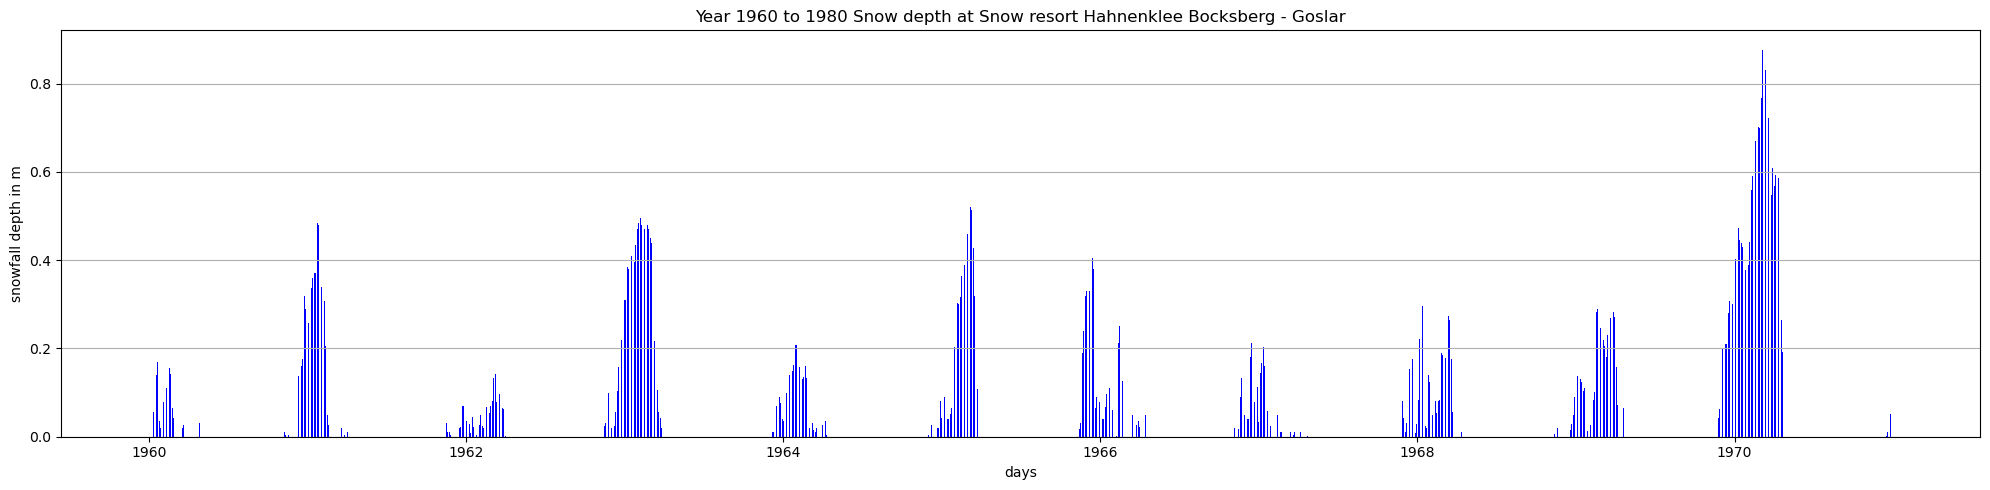

In [132]:
#1960 to 1970
from_1960_to_1970 = open_meto_1950_2023_Snow_daily.loc["1960-01-01":"1970-12-31"]
plot_my_bargraph(20,5,from_1960_to_1970.index,from_1960_to_1970['open_meteo']["1960-01-01":"1980-12-31"],'Year 1960 to 1980 Snow depth at Snow resort Hahnenklee Bocksberg - Goslar','days','snowfall depth in m')

# plt.figure(figsize=(20, 5))
# plt.bar(from_1960_to_1970.index, from_1960_to_1970['open_meteo']["1960-01-01":"1980-12-31"], width=0.5, color='blue')
# plt.title('Year 1960 to 1980 Snow depth at Snow resort Hahnenklee Bocksberg - Goslar')
# plt.xlabel('days')
# plt.ylabel('snowfall depth in m')
# plt.grid(axis='y')
# plt.tight_layout()

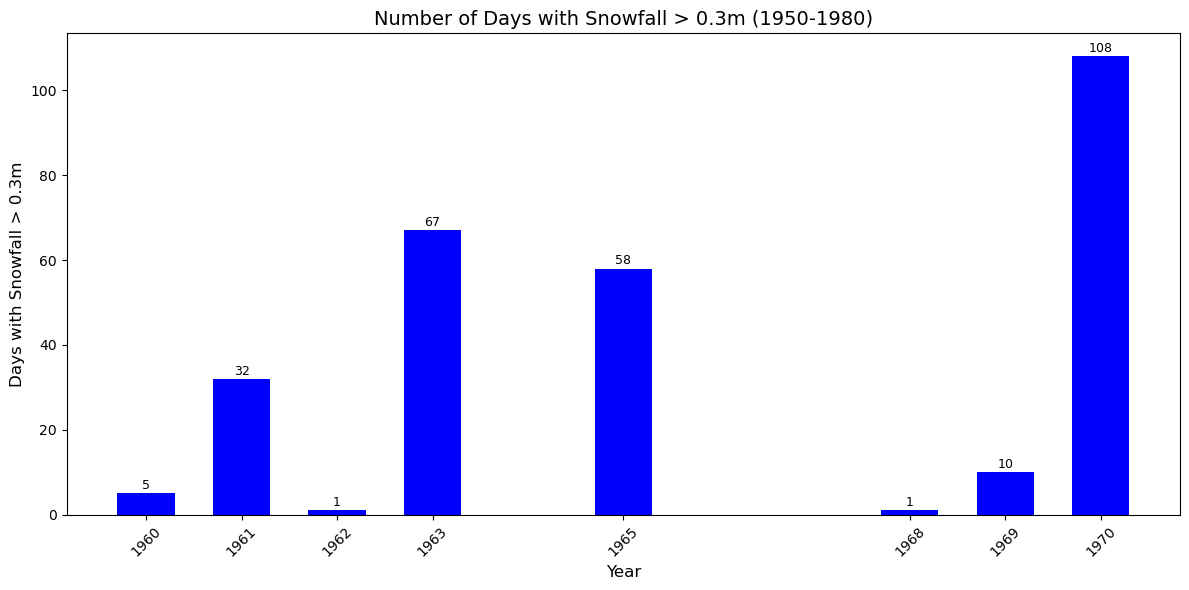

In [133]:
snow_above_threshold = from_1960_to_1970[from_1960_to_1970['open_meteo'] > 0.3]

# Group by year and count the number of days
days_per_year = snow_above_threshold.groupby(snow_above_threshold.index.year).size()

# Plot the results
#plot_my_bargraph(20,6,days_per_year.index,days_per_year.values)
plt.figure(figsize=(12, 6))
plt.bar(days_per_year.index, days_per_year.values, color='blue', width=0.6, align='center')
plt.title('Number of Days with Snowfall > 0.3m (1950-1980)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Days with Snowfall > 0.3m', fontsize=12)
plt.xticks(days_per_year.index, rotation=45, fontsize=10)
for i, value in enumerate(days_per_year.values):
    plt.text(days_per_year.index[i], value + 1, str(value), ha='center', fontsize=9)
plt.tight_layout()
plt.show()

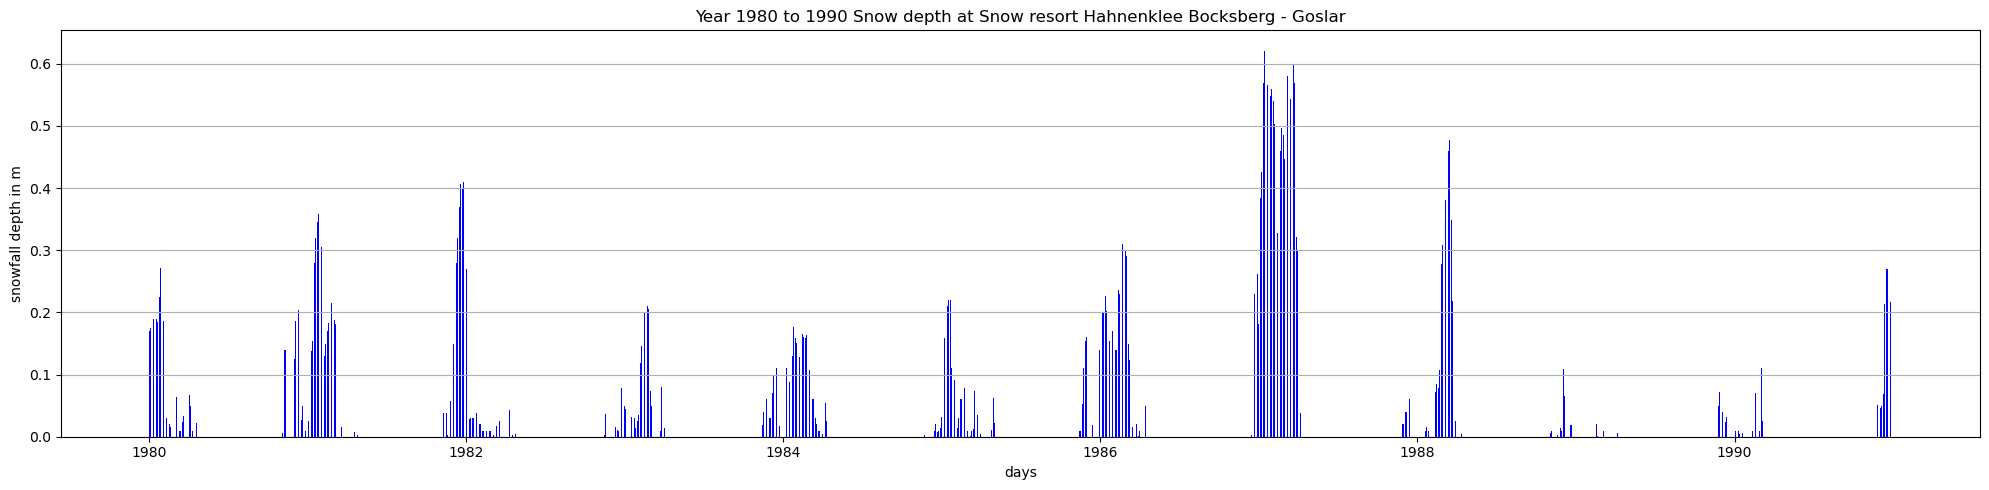

In [183]:
#1971 to 1980
from_1980_to_1990 = open_meto_1950_2023_Snow_daily.loc["1980-01-01":"1990-12-31"]
plot_my_bargraph(20,5,from_1980_to_1990.index,from_1980_to_1990['open_meteo'],'Year 1980 to 1990 Snow depth at Snow resort Hahnenklee Bocksberg - Goslar','days','snowfall depth in m')

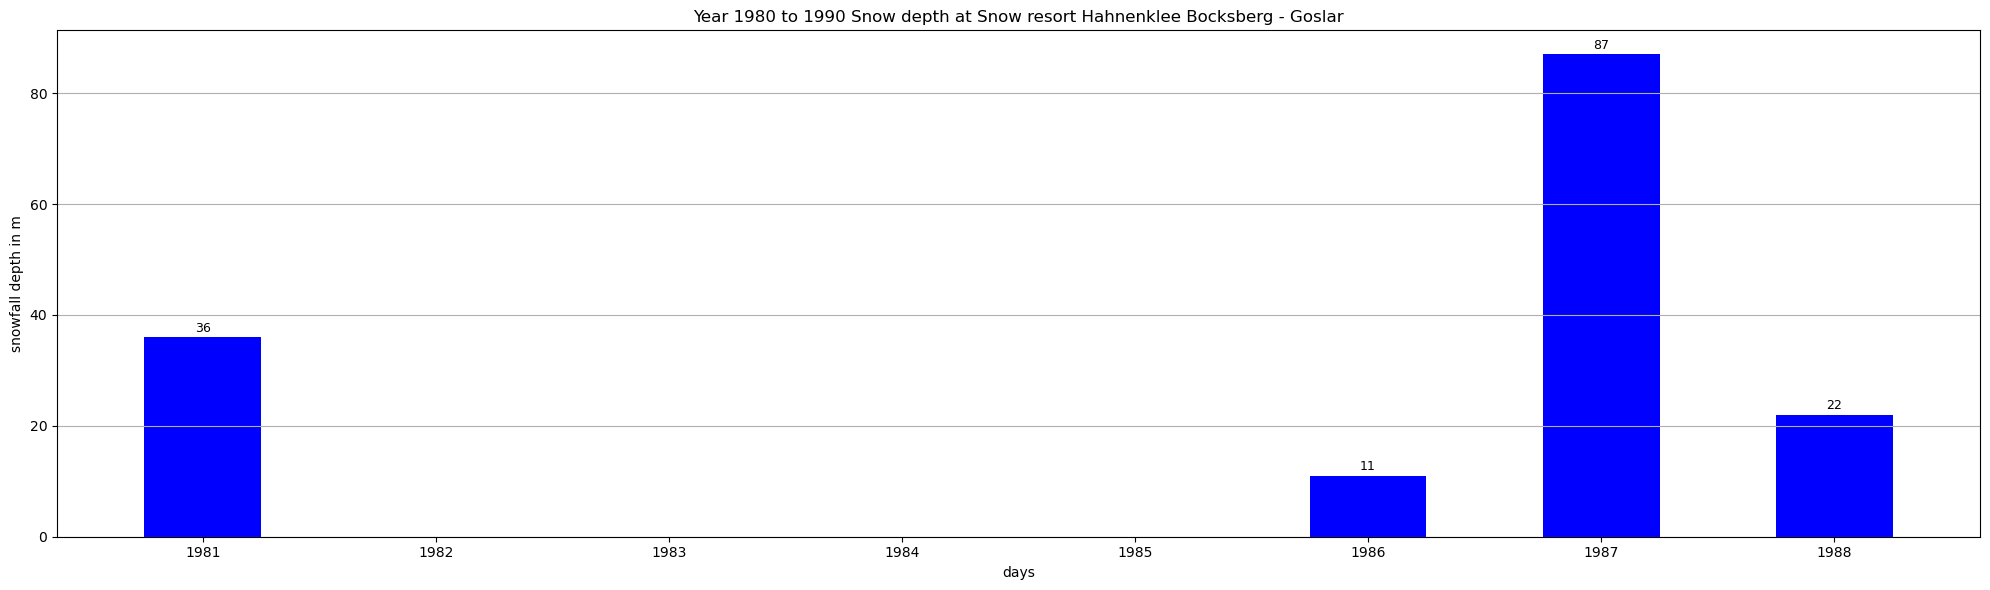

In [135]:
snow_th_from_1980_to_1990 = from_1980_to_1990[from_1980_to_1990['open_meteo'] > 0.3]

# Group by year and count the number of days
days_per_year = snow_th_from_1980_to_1990.groupby(snow_th_from_1980_to_1990.index.year).size()

# Plot the results
plot_my_bargraph_withnumbers(20,6,days_per_year.index,days_per_year.values,'Year 1980 to 1990 Snow depth at Snow resort Hahnenklee Bocksberg - Goslar','days','snowfall depth in m')


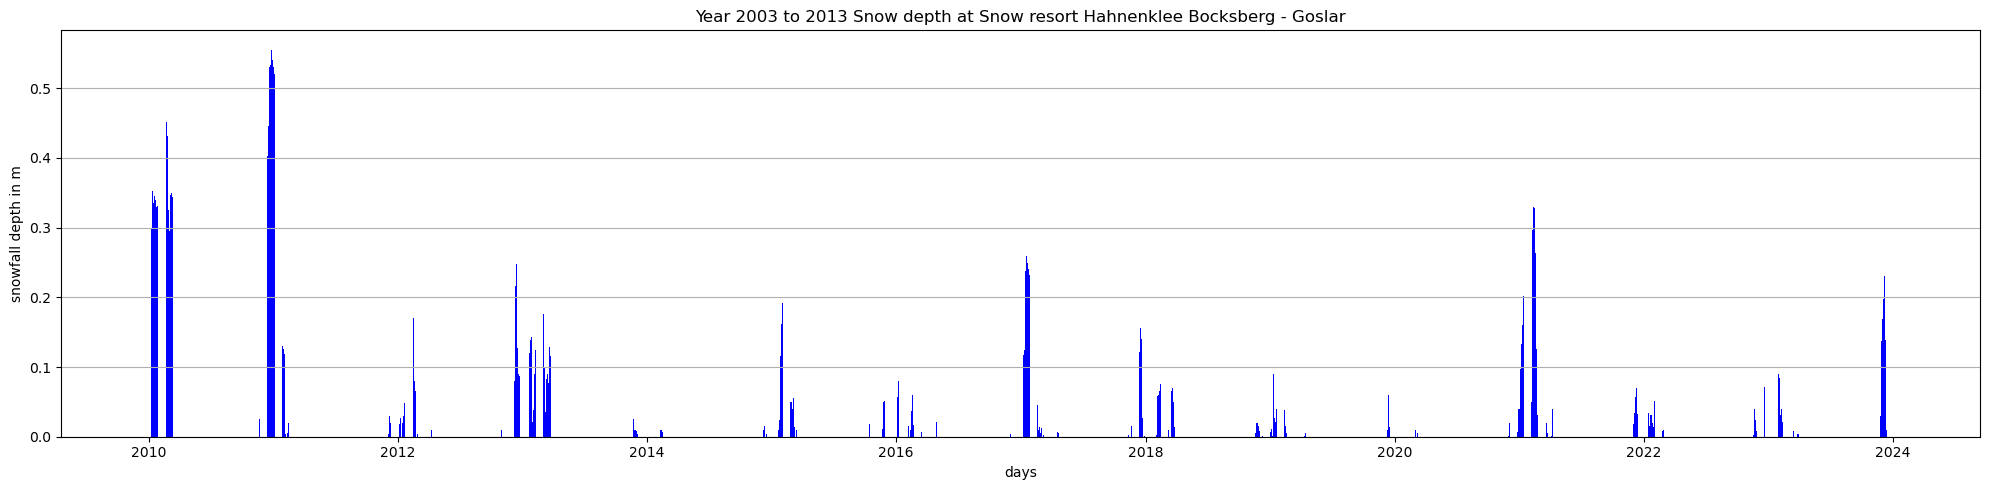

In [178]:
#2003 to 2013
from_2003_to_2013 = open_meto_1950_2023_Snow_daily.loc["2010-01-01":"2023-12-31"]
plot_my_bargraph(20,5,from_2003_to_2013.index,from_2003_to_2013['open_meteo'],'Year 2003 to 2013 Snow depth at Snow resort Hahnenklee Bocksberg - Goslar','days','snowfall depth in m')

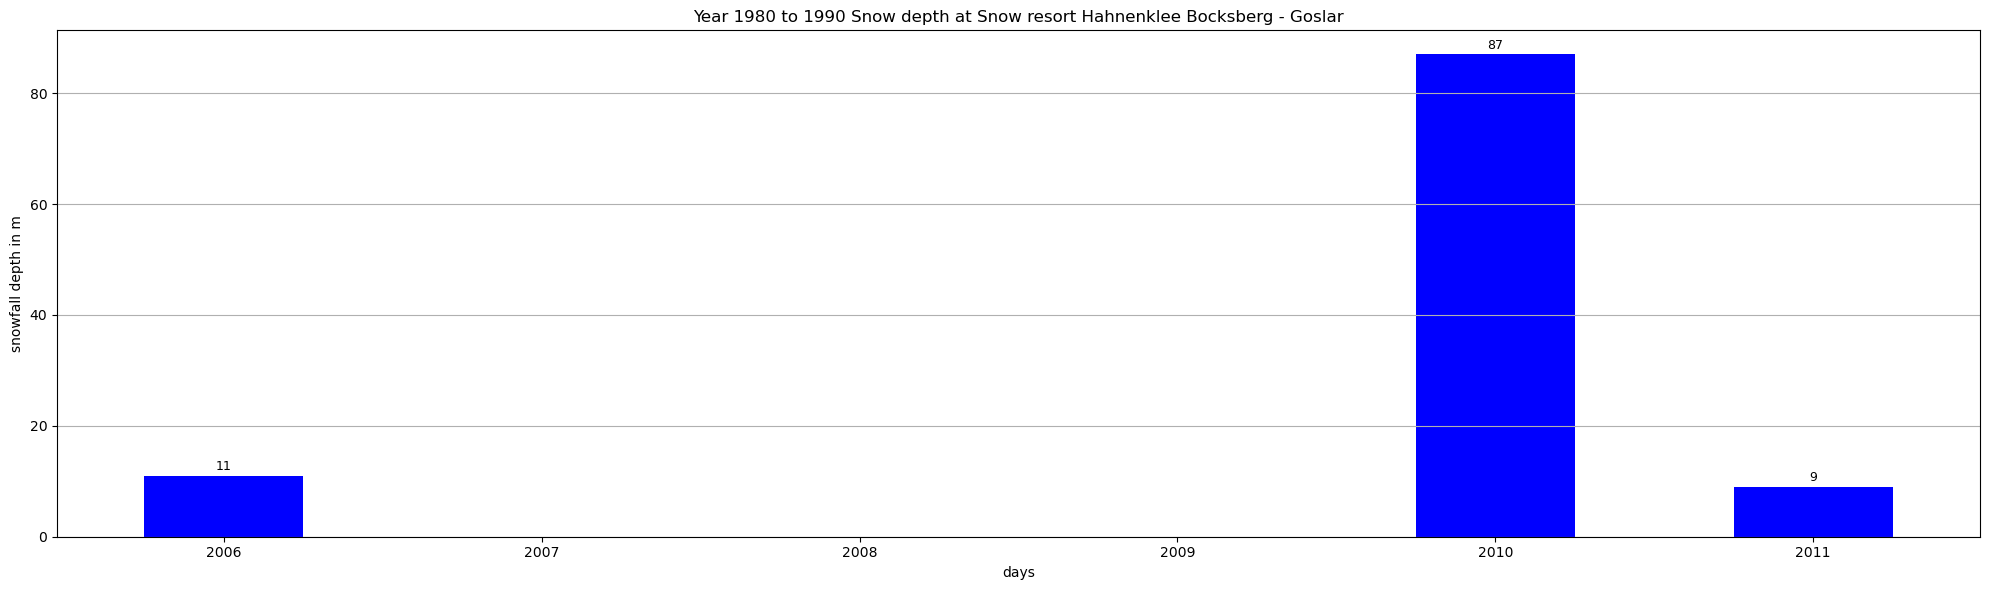

In [137]:
snow_th_from_2003_to_2013 = from_2003_to_2013[from_2003_to_2013['open_meteo'] > 0.3]

# Group by year and count the number of days
days_per_year_2003_to_2013 = snow_th_from_2003_to_2013.groupby(snow_th_from_2003_to_2013.index.year).size()

# Plot the results

plot_my_bargraph_withnumbers(20,6,days_per_year_2003_to_2013.index,days_per_year_2003_to_2013.values,'Year 1980 to 1990 Snow depth at Snow resort Hahnenklee Bocksberg - Goslar','days','snowfall depth in m')

In [138]:
days_per_year_2003_to_2013
open_meto_1950_2023_Snow_daily

,open_meteo
date,
1949-12-31 00:00:00+00:00,NaN
1950-01-01 00:00:00+00:00,0.000000
1950-01-02 00:00:00+00:00,0.018333
1950-01-03 00:00:00+00:00,0.049583
1950-01-04 00:00:00+00:00,0.101250
...,...
2023-12-27 00:00:00+00:00,0.000000
2023-12-28 00:00:00+00:00,0.000000
2023-12-29 00:00:00+00:00,0.000000


In [168]:
# 1 snow resort 
snow_th_from_1950_2023 = open_meto_1950_2023_Snow_daily[open_meto_1950_2023_Snow_daily['open_meteo'] > 0.4]

# Group by year and count the number of days
days_per_year_1950_2023 = snow_th_from_1950_2023 .groupby(snow_th_from_1950_2023 .index.year).size()
print(days_per_year_1950_2023)

date
1952     1
1953    40
1961    10
1963    48
1965    22
1970    96
1979    18
1981     8
1987    73
1988    10
2010    45
2011     7
dtype: int64


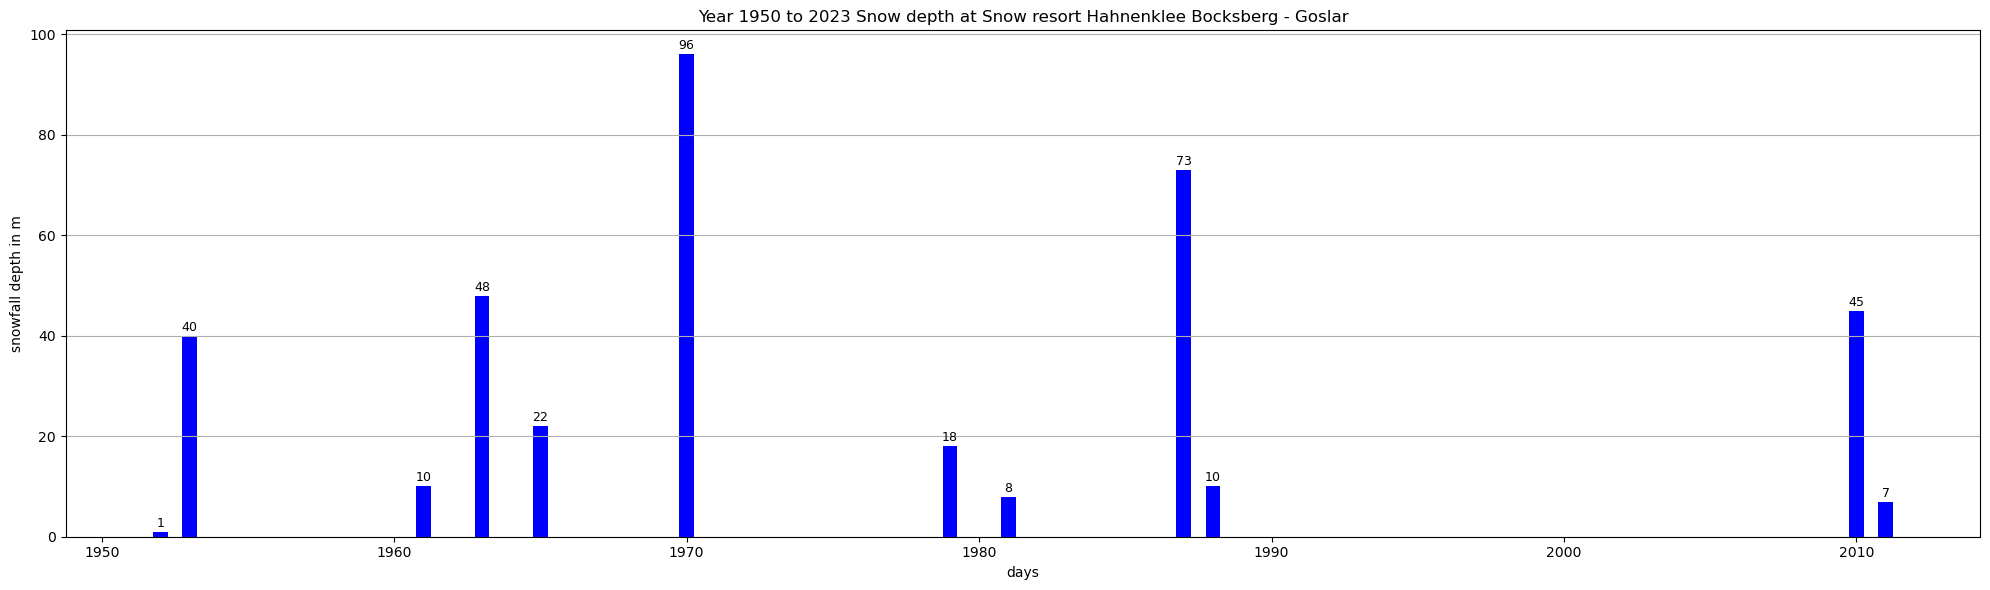

In [169]:
plot_my_bargraph_withnumbers(20,6,days_per_year_1950_2023.index,days_per_year_1950_2023.values,'Year 1950 to 2023 Snow depth at Snow resort Hahnenklee Bocksberg - Goslar','days','snowfall depth in m')

## Snow depth at Snow resort Wurmberg – Braunlage

In [7]:
#51.755646, 10.619693
open_meto_1950_2023_Snow_Wurmberg  = Hourly_open_meteo_data("1950-01-01", "2023-12-31",[51.75], [10.61],"snow_depth")
open_meto_1950_2023_Snow_Wurmberg.fillna(0,inplace=True)
open_meto_1950_2023_Snow_Wurmberg.isna().sum()
open_meto_1950_2023_Snow_Wurmberg.set_index('date',inplace= True)
open_meto_1950_2023_Snow_daily_Wurmberg  = open_meto_1950_2023_Snow_Wurmberg.resample("D").mean()

open_meto_1950_2023_Snow_daily_Wurmberg

,open_meteo
date,
1949-12-31 00:00:00+00:00,0.000000
1950-01-01 00:00:00+00:00,0.000000
1950-01-02 00:00:00+00:00,0.018333
1950-01-03 00:00:00+00:00,0.049583
1950-01-04 00:00:00+00:00,0.101250
...,...
2023-12-27 00:00:00+00:00,0.000000
2023-12-28 00:00:00+00:00,0.000000
2023-12-29 00:00:00+00:00,0.000000


# For yearly calculation

In [ ]:
snow_th_from_1950_2023_Wurmberg = open_meto_1950_2023_Snow_daily_Wurmberg[open_meto_1950_2023_Snow_daily_Wurmberg['open_meteo'] >= 0.3]

# Group by year and count the number of days
days_per_year_1950_2023_Wurmberg = snow_th_from_1950_2023_Wurmberg.groupby(snow_th_from_1950_2023_Wurmberg.index.year).size()
print(days_per_year_1950_2023_Wurmberg)

date
1952     2
1953    40
1961    10
1963    51
1965    23
1970    96
1979    18
1981     9
1987    74
1988    11
2010    45
2011     7
dtype: int64


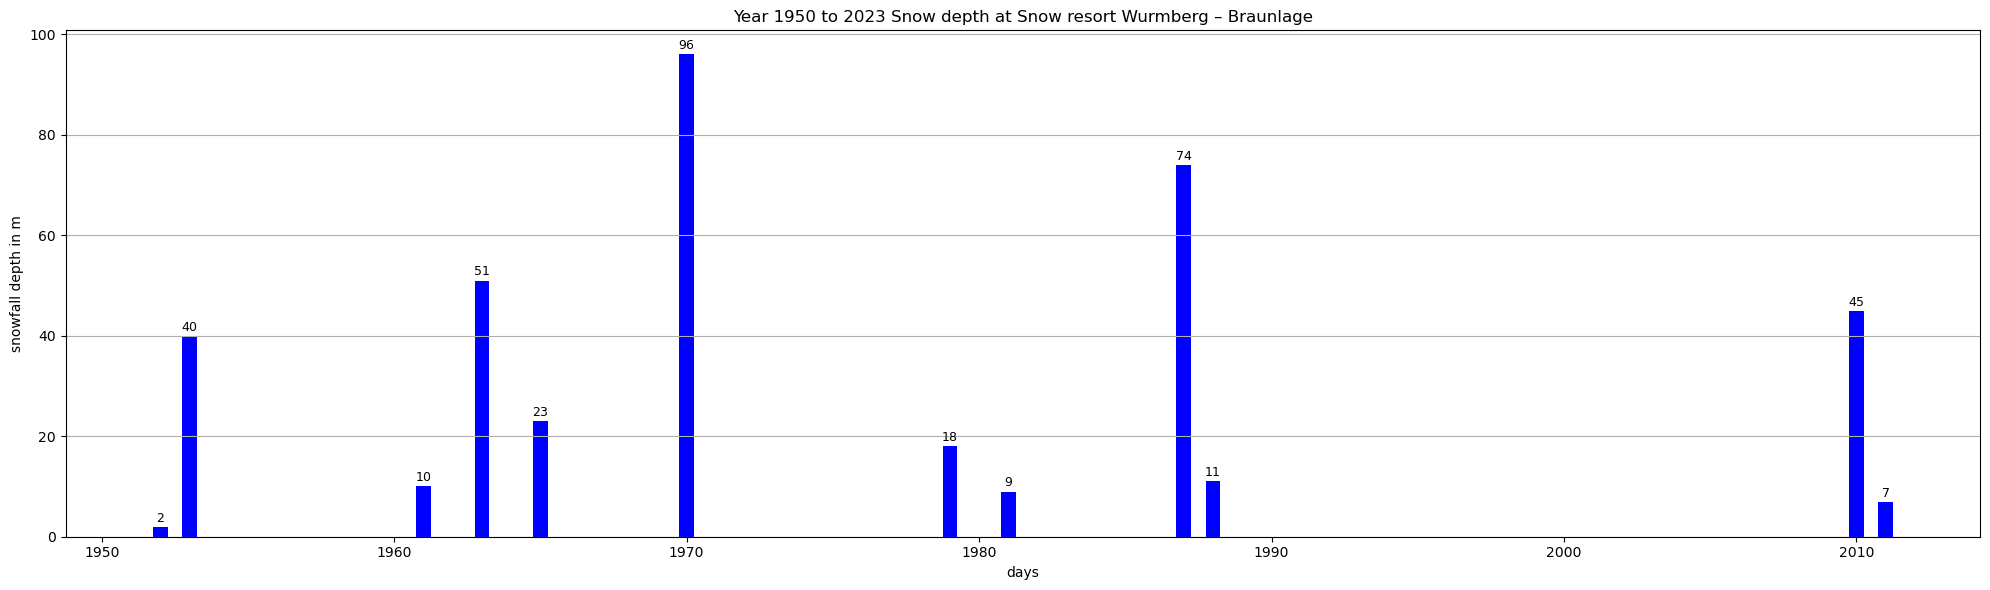

In [175]:
plot_my_bargraph_withnumbers(20,6,days_per_year_1950_2023_Wurmberg.index,days_per_year_1950_2023_Wurmberg.values,'Year 1950 to 2023 Snow depth at Snow resort Wurmberg – Braunlage','days','snowfall depth in m')

# Converted it into Seasonally

In [8]:
open_meto_1950_1990_Snow_season_Wurmberg = open_meto_1950_2023_Snow_daily_Wurmberg["1950-01-01":"1990-12-31"]

C:\Users\rande\AppData\Local\Temp\ipykernel_13000\354053779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] =  dataframe.index.month
C:\Users\rande\AppData\Local\Temp\ipykernel_13000\354053779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['year'] =  dataframe.index.year
C:\Users\rande\AppData\Local\Temp\ipykernel_13000\354053779.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

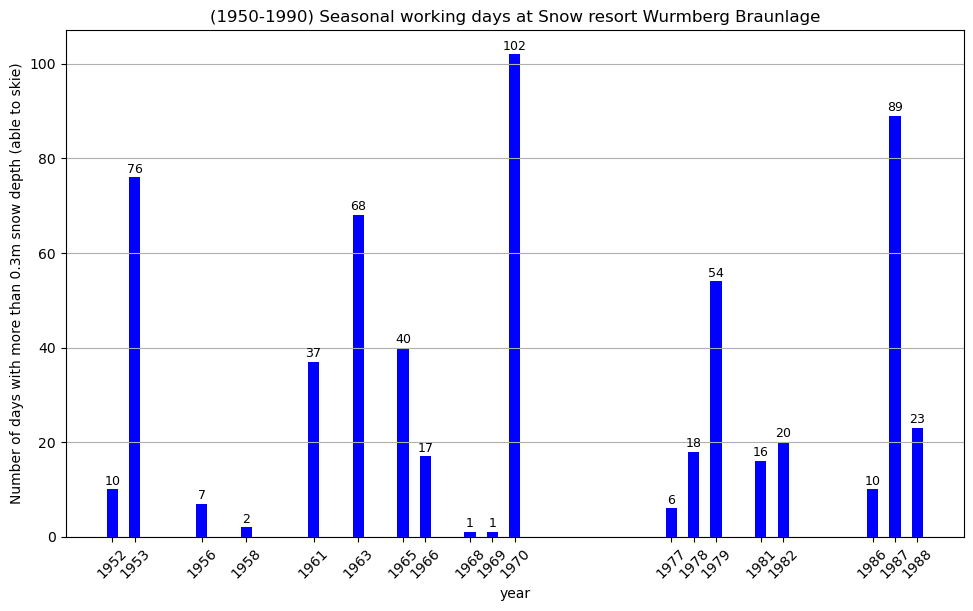

In [9]:
def convert_data_to_season(dataframe):
    dataframe['month'] =  dataframe.index.month
    dataframe['year'] =  dataframe.index.year
    dec_to_mar =  dataframe[(dataframe['month'].isin([ 12, 1, 2, 3]))]

    # Shift year for December to group into the next year's winter
    dec_to_mar['season_year'] = dec_to_mar.apply(
        lambda x: x['year'] if x['month'] != 12 else x['year'] + 1, axis=1
    )

    snow_above_threshold = dec_to_mar[dec_to_mar['open_meteo'] >= 0.3]

    days_with_snowfall = snow_above_threshold.groupby('season_year').size()
    return days_with_snowfall

days_with_snowfall_1950_1990 = convert_data_to_season(open_meto_1950_1990_Snow_season_Wurmberg)
plot_my_bargraph_withnumbers(10,6,days_with_snowfall_1950_1990.index,days_with_snowfall_1950_1990.values,'(1950-1990) Seasonal working days at Snow resort Wurmberg Braunlage','year','Number of days with more than 0.3m snow depth (able to skie)')

C:\Users\rande\AppData\Local\Temp\ipykernel_4372\1875095362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] =  dataframe.index.month
C:\Users\rande\AppData\Local\Temp\ipykernel_4372\1875095362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['year'] =  dataframe.index.year
C:\Users\rande\AppData\Local\Temp\ipykernel_4372\1875095362.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

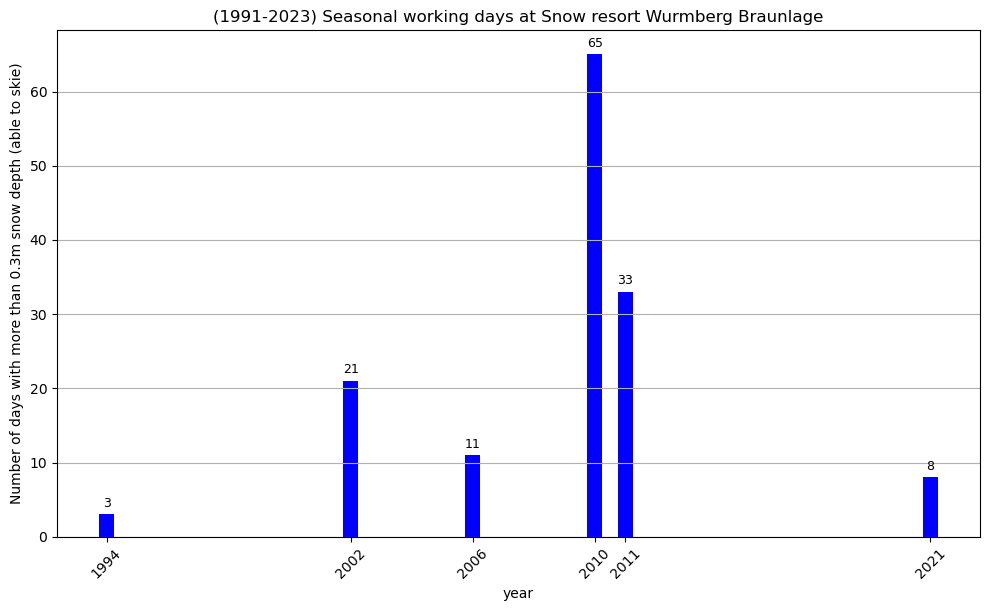

In [203]:
open_meto_1991_2023_Snow_season_Wurmberg = open_meto_1950_2023_Snow_daily_Wurmberg["1991-01-01":"2023-12-31"]
days_with_snowfall_1991_2023 = convert_data_to_season(open_meto_1991_2023_Snow_season_Wurmberg)
plot_my_bargraph_withnumbers(10,6,days_with_snowfall_1991_2023.index,days_with_snowfall_1991_2023.values,'(1991-2023) Seasonal working days at Snow resort Wurmberg Braunlage','year','Number of days with more than 0.3m snow depth (able to skie)')

## Converting the yearly data into decade

In [15]:

days_with_snowfall_1950_2023 = convert_data_to_season(open_meto_1950_2023_Snow_daily_Wurmberg)
#plot_my_bargraph_withnumbers(15,6,days_with_snowfall_1950_2023.index,days_with_snowfall_1950_2023.values,'(1950-2023) Seasonal working days at Snow resort Wurmberg Braunlage','year','Number of days with more than 0.3m snow depth (able to skie)')


C:\Users\rande\AppData\Local\Temp\ipykernel_13000\354053779.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_to_mar['season_year'] = dec_to_mar.apply(


C:\Users\rande\AppData\Local\Temp\ipykernel_13000\3883994745.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_10_average_snowfall_1950_1990 = (days_with_snowfall_1950_2023.groupby(pd.cut(days_with_snowfall_1950_2023.index, ten_year_gap_1950_1990)).sum()/10)


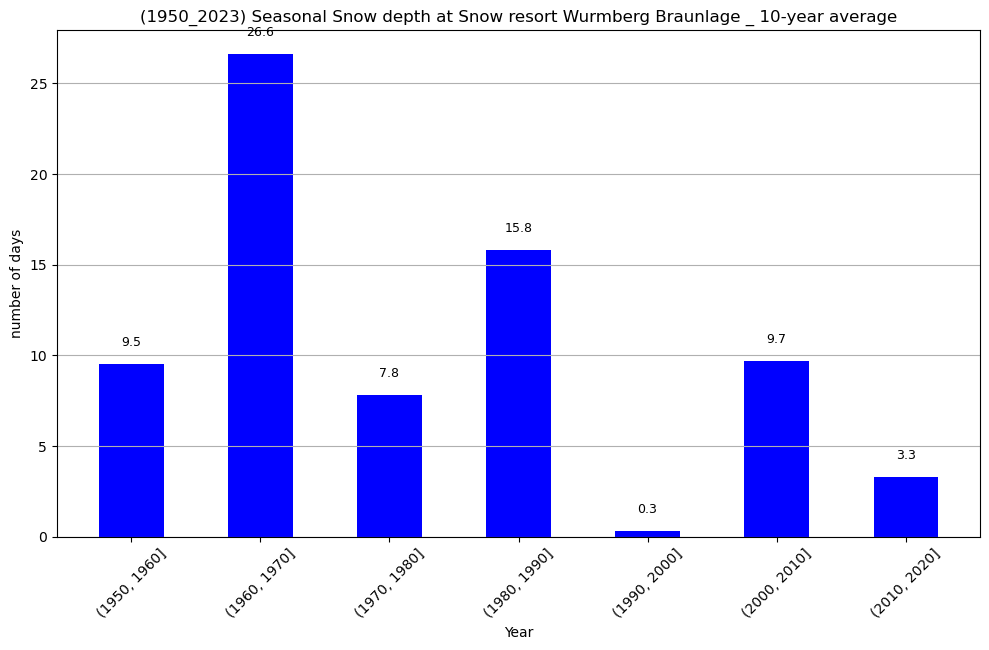

In [33]:
days_with_snowfall_1950_2023.index = days_with_snowfall_1950_2023.index.astype(int)  
ten_year_gap_1950_1990 = range(1950,2030, 10)  # Create 10-year intervals
#year_10_average_snowfall_1950_1990 = days_with_snowfall_1950_2023.groupby(pd.cut(days_with_snowfall_1950_2023.index, ten_year_gap_1950_1990)).mean()
year_10_average_snowfall_1950_1990 = (days_with_snowfall_1950_2023.groupby(pd.cut(days_with_snowfall_1950_2023.index, ten_year_gap_1950_1990)).sum()/10)
#decade_labels_1950_1990 = [f"{int(interval.left)}-{int(interval.right)-1}" for interval in year_10_average_1950_1990.index]
year_10_average_snowfall_1950_1990 .index = year_10_average_snowfall_1950_1990 .index.astype(str)
plot_my_bargraph_withnumbers(10,6,year_10_average_snowfall_1950_1990 .index,year_10_average_snowfall_1950_1990 ,'(1950_2023) Seasonal Snow depth at Snow resort Wurmberg Braunlage _ 10-year average','Year','number of days')


In [ ]:
#plot_my_bargraph(open_meto_2020_2021_Temp_4['date'],open_meto_2020_2021_Temp_4['open_meteo'],'')

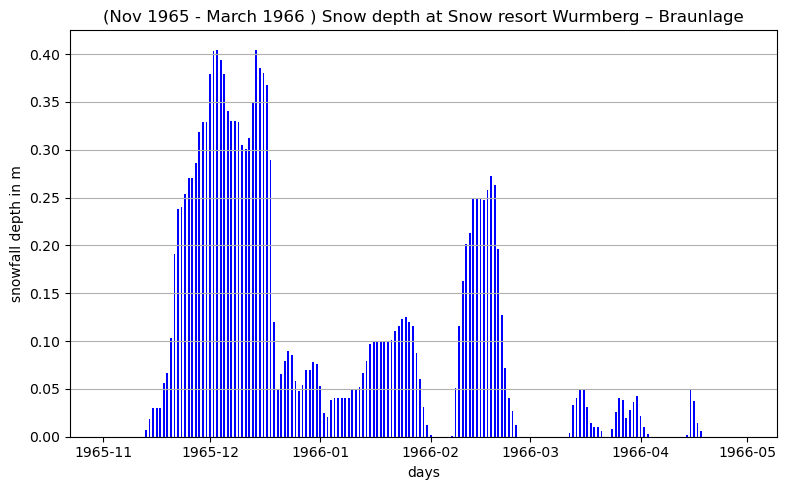

In [15]:
from_1969_to_1970 = open_meto_1950_2023_Snow_daily_Wurmberg.loc["1965-11-01":"1966-04-30"]
plot_my_bargraph(8,5,from_1969_to_1970.index,from_1969_to_1970['open_meteo'],'(Nov 1965 - March 1966 ) Snow depth at Snow resort Wurmberg – Braunlage','days','snowfall depth in m')

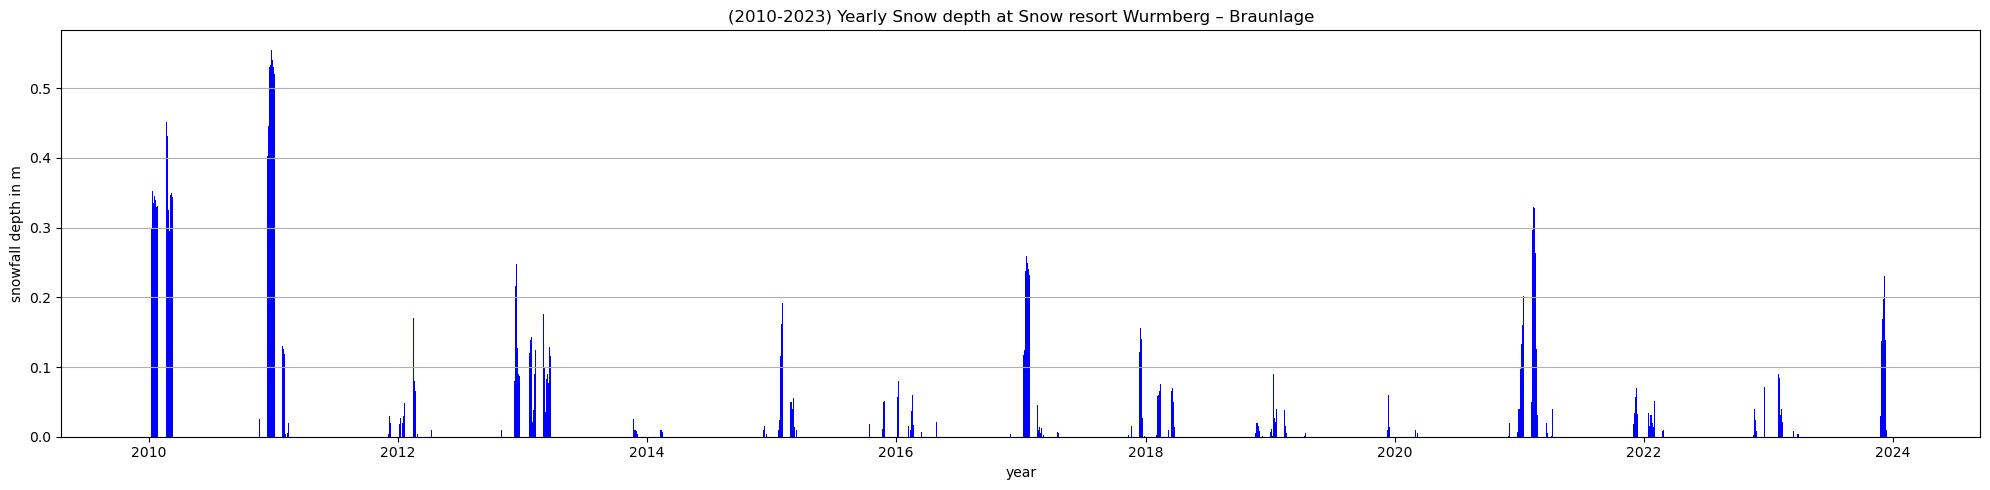

In [207]:
from_2003_to_2013 = open_meto_1950_2023_Snow_daily_Wurmberg.loc["2010-01-01":"2023-12-31"]
plot_my_bargraph(20,5,from_2003_to_2013.index,from_2003_to_2013['open_meteo'],'(2010-2023) Yearly Snow depth at Snow resort Wurmberg – Braunlage','year','snowfall depth in m')

## Wetbulb tempreature

In [18]:
open_meto_1950_2023_wet_bulbTemp_4 = Hourly_open_meteo_data("1950-12-01", "2024-04-30",[51.8], [10.62], "wet_bulb_temperature_2m")
open_meto_1950_2023_wet_bulbTemp_4.fillna(0,inplace=True)
open_meto_1950_2023_wet_bulbTemp_4.isna().sum()
open_meto_1950_2023_wet_bulbTemp_4.set_index('date',inplace= True)
open_meto_1950_2023_wet_bulbTemp_4_Wurmberg  = open_meto_1950_2023_wet_bulbTemp_4.resample("D").mean()
open_meto_1950_2023_wet_bulbTemp_4_Wurmberg

,open_meteo
date,
1950-11-30 00:00:00+00:00,-1.124638
1950-12-01 00:00:00+00:00,0.278249
1950-12-02 00:00:00+00:00,-1.662732
1950-12-03 00:00:00+00:00,-4.639811
1950-12-04 00:00:00+00:00,-6.923136
...,...
2024-04-26 00:00:00+00:00,-0.212059
2024-04-27 00:00:00+00:00,2.412640
2024-04-28 00:00:00+00:00,4.965401


In [19]:
#plot_my_bargraph(20,5,open_meto_1950_2023_wet_bulbTemp_4_Wurmberg.index,open_meto_1950_2023_wet_bulbTemp_4_Wurmberg['open_meteo'],'(2020-2021) Wet bulb tempreature resort Wurmberg – Braunlage','days','Wet bulb Tempreature')

In [20]:
open_meto_1950_1990_wet_bulb_Wurmberg = open_meto_1950_2023_wet_bulbTemp_4_Wurmberg.loc["1950-01-01":"1990-03-31"]
open_meto_1991_2023_wet_bulb_Wurmberg = open_meto_1950_2023_wet_bulbTemp_4_Wurmberg.loc["1990-11-01":"2023-04-30"]

WBT = Wet bulb tempreature

In [21]:
# for flexibiltiy used different defination.
def convert_data_to_season_WBT(dataframe):
    dataframe['month'] =  dataframe.index.month
    dataframe['year'] =  dataframe.index.year
    dec_to_mar =  dataframe.loc[dataframe['month'].isin([12, 1, 2, 3])]

    # Shift year for December to group into the next year's winter
    dec_to_mar.loc[:, 'cold_year'] = dec_to_mar.loc[:, 'year']
    dec_to_mar.loc[dec_to_mar['month'] == 12, 'cold_year'] += 1

    cold_above_threshold = dec_to_mar[dec_to_mar['open_meteo'] <= -2.5]
    #print(dec_to_mar)

    Cold_days = cold_above_threshold.groupby('cold_year').size()
    return Cold_days


C:\Users\rande\AppData\Local\Temp\ipykernel_13000\692318994.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] =  dataframe.index.month
C:\Users\rande\AppData\Local\Temp\ipykernel_13000\692318994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['year'] =  dataframe.index.year
C:\Users\rande\AppData\Local\Temp\ipykernel_13000\692318994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

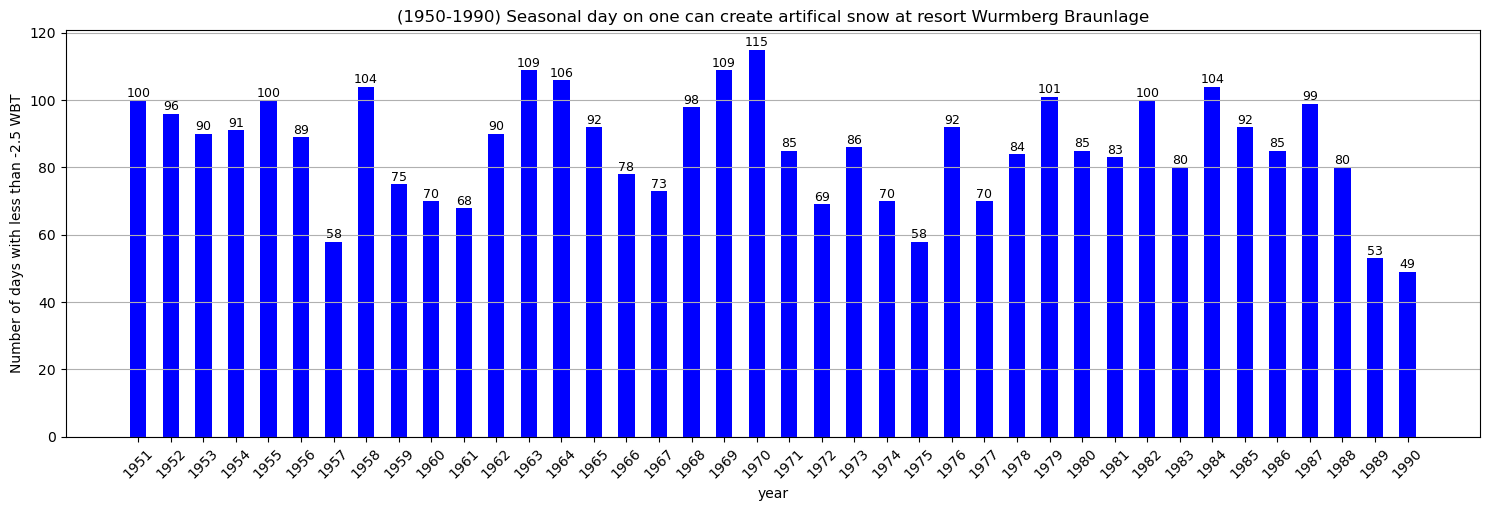

In [22]:
days_with_neg_WBT_temp_1950_1990 = convert_data_to_season_WBT(open_meto_1950_1990_wet_bulb_Wurmberg)
plot_my_bargraph_withnumbers(15,5,days_with_neg_WBT_temp_1950_1990.index,days_with_neg_WBT_temp_1950_1990.values,'(1950-1990) Seasonal day on one can create artifical snow at resort Wurmberg Braunlage','year','Number of days with less than -2.5 WBT')

C:\Users\rande\AppData\Local\Temp\ipykernel_13000\692318994.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] =  dataframe.index.month
C:\Users\rande\AppData\Local\Temp\ipykernel_13000\692318994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['year'] =  dataframe.index.year
C:\Users\rande\AppData\Local\Temp\ipykernel_13000\692318994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

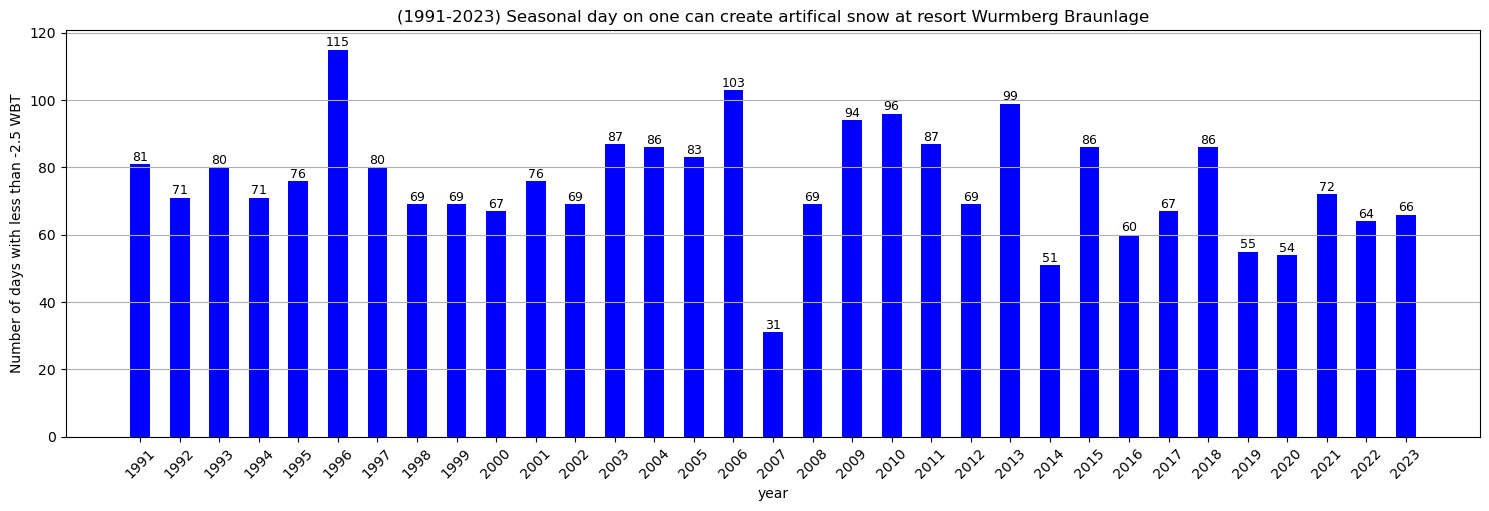

In [23]:
days_with_neg_WBT_temp_1991_2023 = convert_data_to_season_WBT(open_meto_1991_2023_wet_bulb_Wurmberg )
plot_my_bargraph_withnumbers(15,5,days_with_neg_WBT_temp_1991_2023.index,days_with_neg_WBT_temp_1991_2023.values,'(1991-2023) Seasonal day on one can create artifical snow at resort Wurmberg Braunlage','year','Number of days with less than -2.5 WBT')

In [24]:
Mean_days_1951_1960 = days_with_neg_WBT_temp_1950_1990.loc["1951":"1960"].mean()
Mean_days_1951_1960

87.3

C:\Users\rande\AppData\Local\Temp\ipykernel_13000\3004841761.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_10_average_1950_1990 = days_with_neg_WBT_temp_1950_1990.groupby(pd.cut(days_with_neg_WBT_temp_1950_1990.index, ten_year_gap_1950_1990)).mean()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


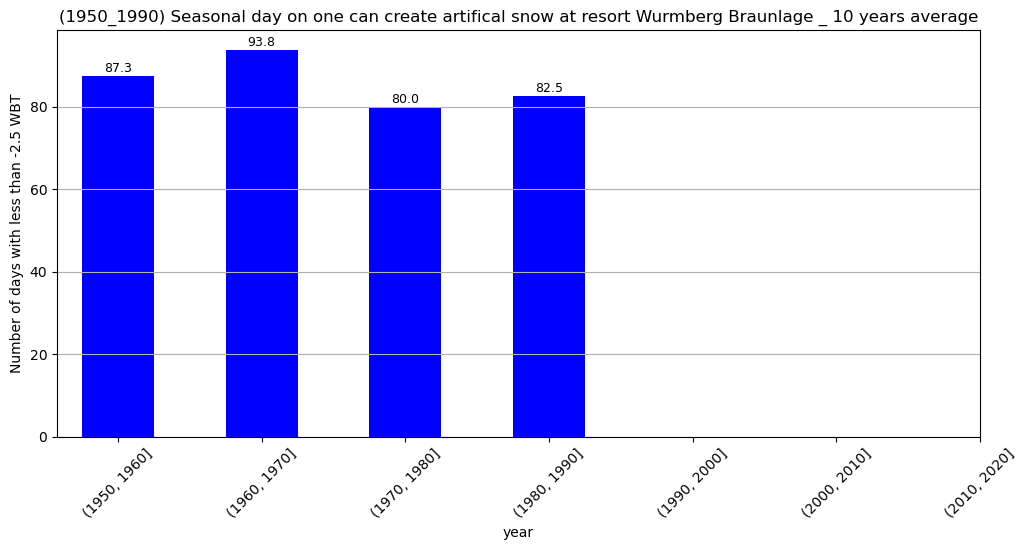

In [25]:

days_with_neg_WBT_temp_1950_1990.index = days_with_neg_WBT_temp_1950_1990.index.astype(int)  
ten_year_gap_1950_1990 = range(1950,2000, 10)  # Create 10-year intervals
year_10_average_1950_1990 = days_with_neg_WBT_temp_1950_1990.groupby(pd.cut(days_with_neg_WBT_temp_1950_1990.index, ten_year_gap_1950_1990)).mean()
#decade_labels_1950_1990 = [f"{int(interval.left)}-{int(interval.right)-1}" for interval in year_10_average_1950_1990.index]
year_10_average_1950_1990.index = year_10_average_1950_1990.index.astype(str)
plot_my_bargraph_withnumbers(10,5,year_10_average_1950_1990.index,year_10_average_1950_1990,'(1950_1990) Seasonal day on one can create artifical snow at resort Wurmberg Braunlage _ 10 years average','year','Number of days with less than -2.5 WBT')


In [27]:
days_with_neg_WBT_temp_1950_2023 = convert_data_to_season_WBT(open_meto_1950_2023_wet_bulbTemp_4_Wurmberg)

C:\Users\rande\AppData\Local\Temp\ipykernel_13000\692318994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_to_mar.loc[:, 'cold_year'] = dec_to_mar.loc[:, 'year']


C:\Users\rande\AppData\Local\Temp\ipykernel_13000\1834025469.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_10_average_1950_2023 = days_with_neg_WBT_temp_1950_2023.groupby(pd.cut(days_with_neg_WBT_temp_1950_2023.index, ten_year_gap_1950_2023)).mean()


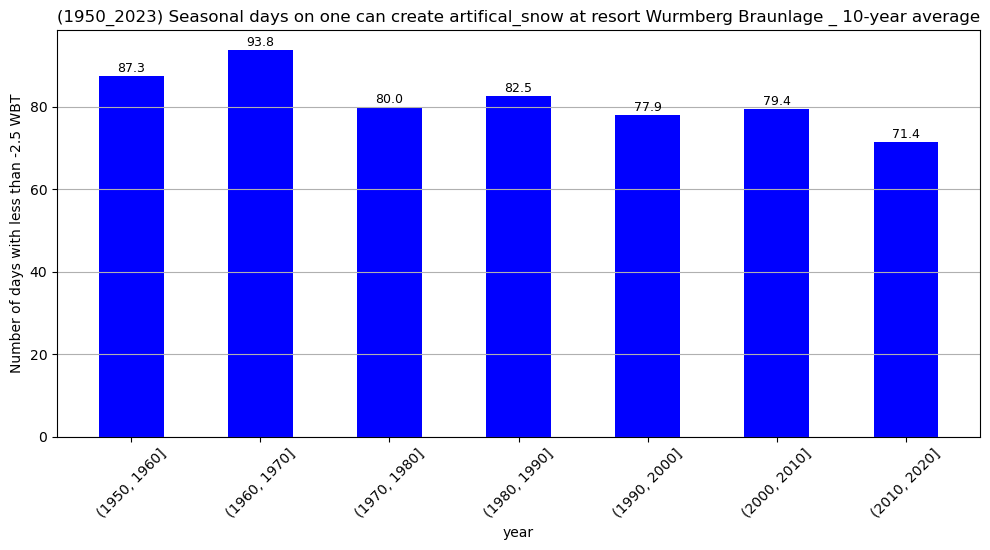

In [32]:
days_with_neg_WBT_temp_1950_2023.index = days_with_neg_WBT_temp_1950_2023.index.astype(int)  
ten_year_gap_1950_2023 = range(1950,2023, 10)  # Create 10-year intervals
year_10_average_1950_2023 = days_with_neg_WBT_temp_1950_2023.groupby(pd.cut(days_with_neg_WBT_temp_1950_2023.index, ten_year_gap_1950_2023)).mean()
#decade_labels_1950_1990 = [f"{int(interval.left)}-{int(interval.right)-1}" for interval in year_10_average_1950_1990.index]
year_10_average_1950_2023 .index = year_10_average_1950_2023 .index.astype(str)
plot_my_bargraph_withnumbers(10,5,year_10_average_1950_2023 .index,year_10_average_1950_2023,'(1950_2023) Seasonal days on one can create artifical_snow at resort Wurmberg Braunlage _ 10-year average','year','Number of days with less than -2.5 WBT')
